In [1]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import RNA
from timeit import default_timer as timer

In [2]:
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

In [3]:
from return_up import return_up

In [8]:
print(return_up("GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"))

[0.9884090936975554, 0.9510886089410633, 0.14273131750087487, 0.040934765864221845, 0.07217651569226291, 0.04748796278727241, 0.029997852951282766, 0.9443878897576496, 0.9661236668262063, 0.9923582335859464, 0.9894882104417775, 0.9808007543128952, 0.9399550724901928, 0.9584043968825426, 0.9840429307823797, 0.035821246325212996, 0.0221723152717459, 0.03718026753153936, 0.0799802839756012, 0.1792680469663992, 0.007014314458274384, 0.002904888190641941, 0.003549573712575693, 0.003161460664614424, 0.007885072569706608, 0.025128389048404642, 0.10857288276793042, 0.9924116147522, 0.9903829278600824, 0.9816617369538108, 0.095630523035652, 0.013157192142557506, 0.00859756486988772, 0.02426628885973514, 0.025583839069099668, 0.011860534060360806, 0.015984469401587376, 0.9829074822720258, 0.993281492261076, 0.997881934424413, 0.9927011997688169, 0.9994261673441542]


# This program is the predictive model for EI based on sequence and secondary structure

From past work (ke et.al 2011), we have a model that scores every hexamer motif and uses those scores to predict the splicing efficiency (proportion of the time an exon is included in a mature RNA sequence). In this notebook. I will demonstrate this model, show its inefficiencies, and attempt to improve the model by factoring in availability, a property of RNA secondary structure.

We will use two inputs.
- hexamer scores from ESRseq 
- secondary structure from RNA fold software

In this jupyter notebook, I will first cover the previous model, which only uses hexamer scores and work towards a more complete model

## The past model
In the ESR paper each hexamer (with 4^6 = 4096 possiblities) was analyzed and evaluated with a score that corresponds to enhacing or silencing. After filtering non significant hexamers, the arising model, which predicts splicing efficiency based on any exon sequence) works by simply adding up the scores of its hexamers.

The following comic shows the process for a short exon

[insert comic of how an 8 base exon gets processed]

### Implementation and Demonstration of the model
In the following 3 blocks of code, we are: importing the hex scores from the ESRseq library, implementing the model, and applying it to a random sequence to see its predicting splicing efficiency (as the log of the enrichment index)

In [9]:
# hex scores come in a dictionary. Only significant ones are included. They represent LEI

datafile = open('./data/ESRseq_scores.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
ESRseq_scores = {}
for row in datareader:
    if row[1] != "":
        ESRseq_scores[row[0]] = float(row[1])
datafile.close()

In [10]:
# the previous model simply adds the enrichment scores of each significant hexamer in the set

def predictLEI_archaic(preMRNA):
    #extract hex sequences from preMRNA
    hexs = [preMRNA[i:i+6] for i in range(len(preMRNA)-5)]
    #list out significant weighted hex scores
    hexLEIs = []
    for hexSeq in hexs:
        if hexSeq in ESRseq_scores:
            hexLEIs.append(ESRseq_scores[hexSeq])
    #average the hex scores, the following code will break if you input a sequence with only insignificant hexs
    sumScores = sum(hexLEIs)
    return(sumScores)

In [11]:
#demonstration of the model

seq = "GAGUAGUGGAACCAGGCUAUGUUUGUGACUCGCAGACUAACA"

print(predictLEI_archaic(seq))

1.2267382


### Application 1: Valcarcel's paper
In a paper by Valcarcel (2016), 189 sequences were observed and had their enrichment indexes measured. With this test set, we can see how our model performs by looking at the correlation between our predictions and his observed values for the log of enrichment index of each sequence.

In [12]:
# import our data
datafile = open('./data/valcarcel_data.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
valcarcel_data = {}
for row in datareader:
    #valcarcel_data[row[0]] = [float(row[1]),0]
    #for 2^EI
    valcarcel_data[row[0]] = [2**float(row[1]),0]
datafile.close()

# write in our predictments
for sequence in  valcarcel_data:
    valcarcel_data[sequence][1] = predictLEI_archaic(sequence)

r^2 = 0.2863736264350571
y = 0.1931773642236244x + 2.24373504624906


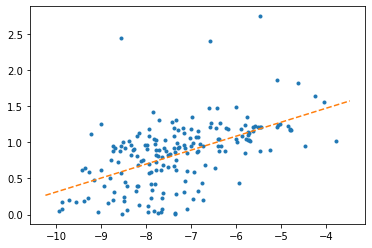

In [13]:
x_vals = []
y_vals = []
for seq in valcarcel_data:
    y_vals.append(valcarcel_data[seq][0]) #x is valcarcel's observations
    x_vals.append(valcarcel_data[seq][1]) #y is our predictment
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
plt.plot(x_vals,y_vals,'.')
abline(slope,intercept)
print("r^2 = " + str(r_value**2))
print("y = " + str(slope) + "x + " + str(intercept))

Oof, that's and r^2 value of 0.28. There is some correlation, but not much. There are many reasons why this can be the case, you can argue that the hexamer scores from the ESRseq scores would only be useful for the specific exons they were made from. I want to argue something different. I think that the method of simply adding hexamer scores is not effective. Here's why

### Application 2: data from the SMS paper (ok, more like a hook than an application)

In this paper (Ke. et.al 2018), a similar model was created but with 7mer scores instead of hexamer scores. 10 variants of an exon were created and 556 of each variant was mutated with a single or double base mutation. Upon graphing predicted 7mer scores against observed 7mer scores for the model, a group of points correlating to a specific variant were seperated from the rest of the points. This variant was also noted in an aalysis of secondary structure. When the correlation between average unpairdness of a 6mer was correlated to the log of the enrichment index, it was found that in the HMA variant, two sites had a high correlation. 

[insert figure 3A and 5B here]

From these results, we think that secondar structure can have an effect on splicing efficiency. If we were to include secondary structure in the past model via the unpairdness of hexamers, we might be able to account for whatever is causing the HMA variant to be deviant from the rest of the graph in figure 1. Additionally, this new feature could improve the model on valcarcel's data.

## The new model
For this new model, we will account for the secondary structure of RNA strands though a measure of availability, which we define as the unpairdness of the bases within a hexamer. Our suspicion is that if bases in a hexamer are strongly bound to other parts of the RNA sequence, then its bases would be less available to RNA binding proteins, making its effect as a motif weaker.

In this model, before we add the scores of each hexamer in a sequence, we will multiply the hexamer by a weight correlating to its availability.

Thus, for an example, the program would do the following:

[insert comic showing the process]

One important factor of this model is that we should be able to know large the weights can be based on availability. Since we cannot arbitrarily choose the range of the weights (and expect good results), we need a scale that sets that range. That way, we can test many different ranges for the weights and find the one that produces the best predictive model

### Explanation of convertion between availability and weight

##### Availability: The expected value
Here, availability is defined as the expected value of unpaired bases within a hexamer. This is a number between 0 and 6. If a number is a decimal, then that is because that the hexamer has different possibilities for amount of unpaired bases. The expected value is the average of unpaired bases among those structures weighted by each structures frequency. Here is an example:

In a hexamer, 50 percent of the time, it has 4 bases unpaired. the other 50 percent of the time, it has no bases unpaired. The expected value of unparied bases is 2.

For the MFE, the expected value of unpaired bases in a hexamer is an integer since the MFE represents only one structure

#### Scale: translates the availability to the weight
I am multiplying the hex score by a weight determined by availability and a scale. To determine how impactful the scale can be, I set the weight betwee a value 1-x and 1+x, where x is the scale. Lets look at a few cases to understand

- x is 1, this is the max. The hexamer's effect as a motif is multiplied by a weight between 0 and 2 (corresponding to no and complete availability)
- x is 0, this is the min. The hexamer's effect as a motif is not changed and the model reverts to the previous model that does not consider secondary structure. This is the control

by setting x to multiple values, we can optimize the model by trial and error.

#### The transformation
We want an availability of 0 to correspond to 1-x for a weight and an availability of 6 to correspond to 1+x. The following function does that for me.

$$
weight = f(availability) = 1 + x(\frac{availability}{3}-1)
$$

This is what the tranformation (not linear by the way since 0's don't line up) looks like on number lines.

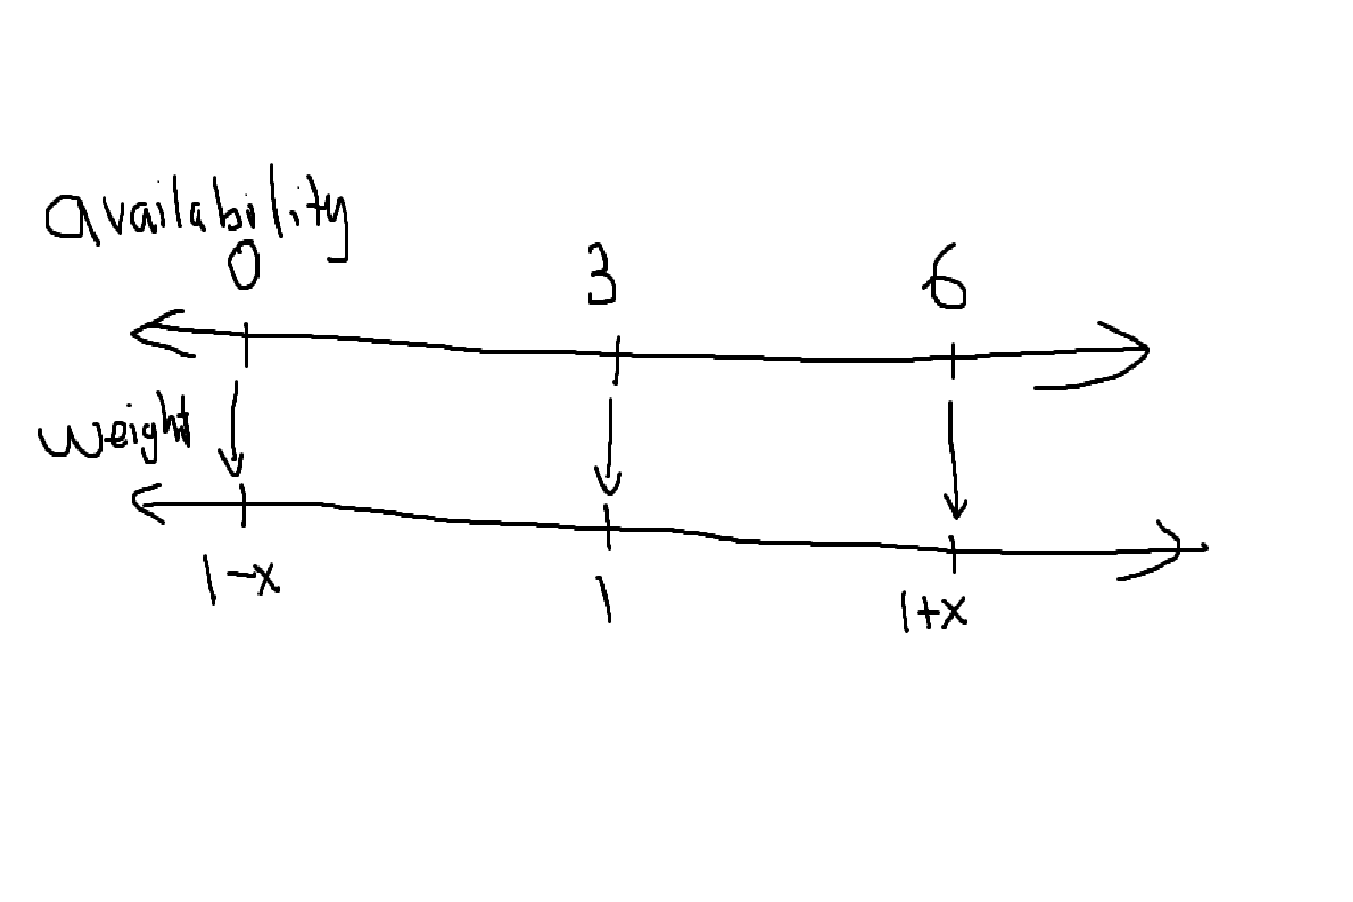

### Implmentation and demonstration of the model

Since we already imported the hex scores in the implementation of the previous model, we will skip that step here.

In [14]:
#we will define this function where x is the scale for the weights
def predictLEI(preRNA, left_flank_length, right_flank_length, scale):
    #keep a list of hex scores * scaled availability
    newHexScores = []
    #mfe as follows, then pc
    #folded = RNA.fold(preRNA)[0]
    up_probs = return_up(preRNA)
    
    #print(folded)
    for i in range(left_flank_length,len(preRNA)-right_flank_length-5):
        if preRNA[i:i+6] in ESRseq_scores:
            #the expected value here is dependent on the a single structure (MFE), so it will always be an exact integer
            #expected_val_up = folded[i:i+6].count('.')
            #with the pc
            expected_val_up = sum(up_probs[i:i+6])
            #print("expected_val_up: " + str(expected_val_up))
            #the following factor scales the expected value
            weight = 1 + (scale * ((expected_val_up / 3) - 1))
            newHexScores.append(ESRseq_scores[preRNA[i:i+6]] * weight)
            #print("ESR score: " + str(ESRseq_scores[preRNA[i:i+6]]) + " weight: " + str(weight))
    #average the hex scores, the following code will break if you input a sequence with only insignificant hexs
    sumScores = sum(newHexScores)
    return(sumScores)

In [18]:
#demonstration with Valcarcel's wild type
full_seq = 'TGTCCAATGTTCCAACCTACAGgatccagatctaacttggggtggctttgtcttcttctt\
ttgccaattccactaattgtttgggGTAAGTTCTTGCTTTGTTCAAA'
full_seq = full_seq.upper()

print()
print(predictLEI(full_seq.upper(),22,22,.1))


print(predictLEI('gatccagatctaacttggggtggctttgtcttcttcttttgccaattccactaattgtttggg'.upper(),0,0,0))


-7.905608426118307
-7.54730749


# Finding the right scale: using HMA variant of WT1 exon in SMS paper

In [19]:
#import sequences and EI values
datafile = open('./data/sms_hma_results.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
hma_data = {}
for row in datareader:
    #have to add flanks
    #row[0] is sequence, row[1] is EI, row[2] is rel EI, row[3] is PUP, row[4] is LEI and row[5] is LEIsc
    hma_data[row[0]] = [float(row[4]),0]
datafile.close()

### Let's test this with a weight of 0, to see the control

r^2 = 0.47829121435022326
y = 1.2264475055967037x + -4.881857153677382


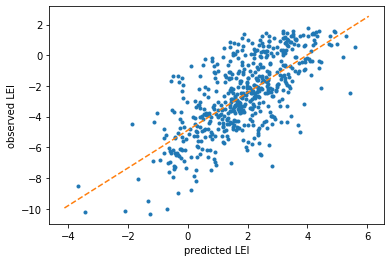

In [20]:
#test this with one scale
for sequence in hma_data:
    hma_data[sequence][1] = predictLEI(sequence,23,16,0)
    # 23 is the length of the left flank and the 16 is the length of the right flank

x_vals = []
y_vals = []

for sequence in hma_data:
    x_vals.append(hma_data[sequence][1]) #x is predicted
    
for sequence in hma_data:
    y_vals.append(hma_data[sequence][0]) #y is observed
    
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
plt.plot(x_vals,y_vals,'.')
plt.xlabel("predicted LEI")
plt.ylabel("observed LEI")
abline(slope,intercept)
print("r^2 = " + str(r_value**2))
print("y = " + str(slope) + "x + " + str(intercept))

### Ok, while we are at it, let's look for the r^2 = .84 result. I assume it will be a little smaller since I am using ESR scores and not SMS scores

The orange points are HMA. I guess I wasn't able to replicate the results

r^2 = 0.7220018349074973
y = 0.9501735108438513x + -3.9756669408117666


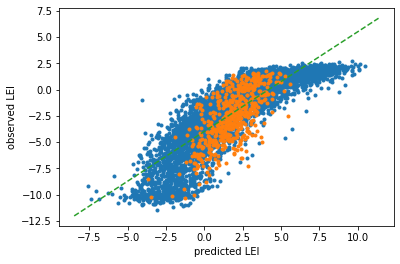

In [46]:
datafile = open('./data/sms_all_results.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
all_data = {}
hma_data = {}
rest_data = {}
i = 0
for row in datareader:
    #have to add flanks
    #row[0] is sequence, row[1] is EI, row[2] is rel EI, row[3] is PUP, row[4] is LEI and row[5] is LEIsc
    if i < 557:
        hma_data[row[0]] = [float(row[4]),0]
    else:
        rest_data[row[0]] = [float(row[4]),0]
    i = i+1
    all_data[row[0]] = [float(row[4]),0]
datafile.close()

for sequence in all_data:
    all_data[sequence][1] = predictLEI(sequence,23,16,0)
    # 23 is the length of the left flank and the 16 is the length of the right flank

for sequence in hma_data:
    hma_data[sequence][1] = predictLEI(sequence,23,16,0)
    
for sequence in rest_data:
    rest_data[sequence][1] = predictLEI(sequence,23,16,0)
    
x_vals = []
y_vals = []

#for the calculation of r^2 and line of best fit
for sequence in all_data:
    x_vals.append(all_data[sequence][1]) #x is predicted
for sequence in all_data:
    y_vals.append(all_data[sequence][0]) #y is observed
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)

#other points
x_vals = []
y_vals = []
for sequence in rest_data:
    x_vals.append(rest_data[sequence][1]) #x is predicted
for sequence in rest_data:
    y_vals.append(rest_data[sequence][0]) #y is observed
plt.plot(x_vals,y_vals,'.')

#hma points
x_vals = []
y_vals = []
for sequence in hma_data:
    x_vals.append(hma_data[sequence][1]) #x is predicted
for sequence in hma_data:
    y_vals.append(hma_data[sequence][0]) #y is observed
plt.plot(x_vals,y_vals,'.')

# rest of plot and equation
plt.xlabel("predicted LEI")
plt.ylabel("observed LEI")
abline(slope,intercept)
print("r^2 = " + str(r_value**2))
print("y = " + str(slope) + "x + " + str(intercept))

### Ok, now let's do this for many weights and find the best scale.

In [21]:
#data is a dictionary with sequences for keys and [observed,0] for values
def plot_scale_performance(data,left_flank_length, right_flank_length):
    y_vals = []
    x_vals = []
    scale_performance = []
    #following loop will take a few minutes
    for x in range(-20,51):
        for sequence in  data:
            data[sequence][1] = predictLEI(sequence,left_flank_length,right_flank_length,x/50)
        for seq in data:
            y_vals.append(data[seq][0]) # y is observed
            x_vals.append(data[seq][1]) # x is predicted
        slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
        scale_performance.append([x/50, r_value**2])
        x_vals = []
        y_vals = []
    plt.plot([item[0] for item in scale_performance],[item[1] for item in scale_performance],'.')
    slope, intercept, r_value, p_value, std_err = stats.linregress([item[0] for item in scale_performance],\
                                                                   [item[1] for item in scale_performance])
    plt.xlabel("scale")
    plt.ylabel("performance: r^2 of observed v. predicted")
    abline(slope,intercept)
    plt.axvline(x=0)
    print("r^2 = " + str(r_value**2))
    print("y = " + str(slope) + "x + " + str(intercept))
    return(scale_performance)
#scale_performance is a list of [scale, r^2 performance]

r^2 = 0.9228024771860587
y = -0.20438522472510548x + 0.4536123832552559


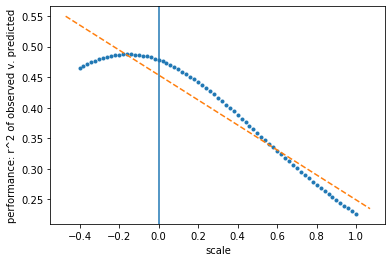

In [22]:
sms_demonstration = plot_scale_performance(hma_data, 23,16)

In [104]:
start = timer()

scale_performance = []

#y doesn't change so let's do that first
y_vals = []
x_vals = []

for x in range(-20,51):
    for sequence in  hma_data:
        hma_data[sequence][1] = predictLEI(sequence,23,16,x/50)
    for seq in hma_data:
        y_vals.append(hma_data[seq][0]) # y is observed
        x_vals.append(hma_data[seq][1]) # x is predicted
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
    scale_performance.append([x/50, r_value**2])
    x_vals = []
    y_vals = []
    
end = timer()
print(end - start)

137.25020829999994


r^2 = 0.9484175340495615
y = -0.31215865889625083x + 0.4565186175266532


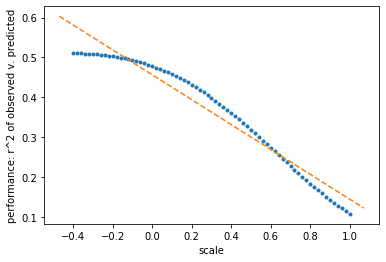

In [114]:
plt.plot([item[0] for item in scale_performance],[item[1] for item in scale_performance],'.')
slope, intercept, r_value, p_value, std_err = stats.linregress([item[0] for item in scale_performance],[item[1] for item in scale_performance])
plt.xlabel("scale")
plt.ylabel("performance: r^2 of observed v. predicted")
abline(slope,intercept)
print("r^2 = " + str(r_value**2))
print("y = " + str(slope) + "x + " + str(intercept))

Ok, takeaway: making the scale bigger just makes the model worse. And this is when I fit the test data against the data used to make the model (so it doesn't even overfit). This is the worst possible outcome. I think Though the fact that it get's better as we go negative is odd. (That doesn't happen for valcarcel's data)

# Takeaways as of 6/25
So first, this doesn't look to optimistic. I can't get better correlation against the HMA data even when I fit the model with the HMA data. But there is still to try out
- the partition function
- what is the upstream and downstream arm? are we not measuring the splicing of all of it?
- Look into how what values are added. Why are we using LEI values? It makes since since it emphasizes small and large EI values alike, but in that case, we can also try PUP or relative EI.
- Should we be adding scores? I think we should do something like a assymptotic curve to account for the >100 percent splicing. For example, if 2 motifs applies 50 percent better splicing, then the combined strength is 75 percent splicing.

On the side I want to improve this documentation to
- thoroughly explain the background
- have a table of contents
- modularize code to remove redundancy as I apply these techniques to multiple data sets.


1. Add partition part
2. Apply model to subset of sms data that corresponds to mutations within SL6 (27 - 49)

## Now, we use this model on valcarcel's data.

In [14]:
# import our data
datafile = open('./data/valcarcel_data.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
valcarcel_data = {}
for row in datareader:
    #have to add flanks
    valcarcel_data['TGTCCAATGTTCCAACCTACAG' + row[0] + 'GTAAGTTCTTGCTTTGTTCAAA'] = [2**float(row[1]),0]
datafile.close()
# write in our predictments

r^2 = 0.5981550981363966
y = -0.08580335955355405x + 0.261843076890336


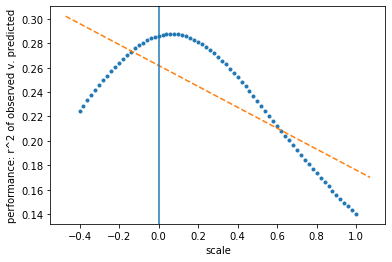

In [21]:
valcarcel_demonstration = plot_scale_performance(valcarcel_data,22,22)

r^2 = 0.2863736264350571
y = 0.1931773642236244x + 2.24373504624906


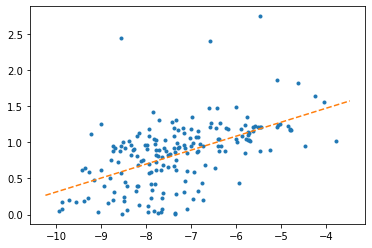

In [113]:
#graph data
def abline(slope, intercept):
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

x_vals = []
y_vals = []
for seq in valcarcel_data:
    y_vals.append(valcarcel_data[seq][0]) #y is valcarcel's observations
    x_vals.append(valcarcel_data[seq][1]) #x is predictions
slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
plt.plot(x_vals,y_vals,'.')
abline(slope,intercept)
print("r^2 = " + str(r_value**2))
print("y = " + str(slope) + "x + " + str(intercept))

In [58]:
# system for trying many x values

start = timer()

# import our data
datafile = open('./data/valcarcel_data.csv', 'r')
datareader = csv.reader(datafile, delimiter=',')
valcarcel_data = {}
for row in datareader:
    #have to add flanks
    valcarcel_data['TGTCCAATGTTCCAACCTACAG' + row[0] + 'GTAAGTTCTTGCTTTGTTCAAA'] = [2**float(row[1]),0]
datafile.close()


x_vals = []
y_vals = []
scale_performace = {}
for x in range(0,6):
    for sequence in  valcarcel_data:
        valcarcel_data[sequence][1] = predictLEI(sequence,22,x/5)
    for seq in valcarcel_data:
        y_vals.append(valcarcel_data[seq][0]) #x is valcarcel's observations
        x_vals.append(valcarcel_data[seq][1]) #y is our predictment
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_vals,y_vals)
    scale_performace[x/5] = r_value**2
    x_vals = []
    y_vals = []
    
    
end = timer()
print(end - start)

5.601586499999939


In [ ]:
# for the future

# seqfc = RNA.fold_compound(seq)
 
# md = RNA.md()
# md.computebpp = 1
# fc = RNA.fold_compound(seq, md)
# print(fc.probs_window(fc, 20, PROBS_WINDOW_UP))
